# Conversation summarization project (BART and T5)

## 0/ Config Google colab and Google drive

In [1]:
# # Config Google_colab and Google_drive :
# from google.colab import drive
# drive.mount('/content/drive')

# #change directory :
# os.chdir(r'./drive/MyDrive/Data_science/PROJET_perso/NLP_project/Notebook')

## 1/ Import package

In [2]:
import pandas as pd
import os 
os.getcwd()

'/kaggle/working'

## 2/ Collect data

In [3]:
# import data (training part) : 

df_train = pd.read_parquet(r"/kaggle/input/data-txt-summarisation/Data/training_data/conv_train.parquet", engine="pyarrow")
df_val1 = pd.read_parquet(r"/kaggle/input/data-txt-summarisation/Data/training_data/conv_val1.parquet", engine="pyarrow")
df_val2 = pd.read_parquet(r"/kaggle/input/data-txt-summarisation/Data/training_data/conv_val2.parquet", engine="pyarrow")

df_train

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."
...,...,...,...
14727,13863028,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...
14728,13828570,Theresa: <file_photo>\nTheresa: <file_photo>\n...,Theresa is at work. She gets free food and fre...
14729,13819050,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...
14730,13828395,Jennifer: Dear Celia! How are you doing?\nJenn...,Celia couldn't make it to the afternoon with t...


In [4]:
# Analyse some examples :
def print_example(df, txt_id) : 
    print(f"dialogue : \n{df['dialogue'].loc[txt_id]}")
    print(" ")
    print(f"summary : \n{df['summary'].loc[txt_id]}")

print_example(df_train, 60)

dialogue : 
Oli: I've talked to some people from the third year
Jacob: About the statistics exam?
Marcia: What did they say?
Oli: Yeah, about the exam
Oli: We need to prepare for a battle
Jacob: So it will be difficult
Oli: They said it was the hardest exam ever
Marcia: 😱
Oli: The questions were displayed on the screen 
Oli: One minute per question and it disappears
Oli: They won't come back so if you didn't get your answer you're fucked
Marcia: So we need to make the calculations really fast
Jacob: That's insane
Oli: I know
Oli: Very stressful
Marcia: How are we even supposed to study for it?
Marcia: With a timer?
Oli: I guess
Marcia: Did anybody pass it last year
Oli: Some people did, but the majority had to take the second or even the third chance
 
summary : 
Oli, Jacob and Marcia have to prepare for a very hard statistics exam. Last year, people had only one minute to answer each question and then it disappeared.


## 3/ Split df into df_train/df_val1/df_val2 : (already done)

## 4.1/ Data cleaning 1

In [5]:
# rename col [df_train.rename(columns={"A": "a", "B": "c"})] : {"A": "a", "B": "c"}
col_to_rename = {"id" : "id", "dialogue" : "dialogue", "summary" : "summary"}

# Check and change col type (with new col name):
col_type = {"id" : "object", "dialogue" : "object", "summary" : "object"}

# Useless columns (set) : {}
useless_columns = None

In [6]:
# Data cleaning function : 
def data_cleaning_1(df, col_to_rename=None, col_type=None, useless_columns=None):
    
    # Deep copy : 
    df_new = df.copy()
    
    # Rename columns if col_to_rename is provided and not empty
    if col_to_rename:
        df_new = df_new.rename(columns=col_to_rename)
    
    # Check and change column types if col_type is provided
    if col_type:
        for col in df_new.columns : 
            df_new[col] = df_new[col].astype(col_type[col])
            
    # Remove duplicates
    df_new = df_new.drop_duplicates().reset_index(drop=True)
    
    # Drop useless columns if useless_columns is provided
    if useless_columns:
        df_new = df_new.drop(list(useless_columns), axis=1)
    
    # Remove rows with NaN in "dialogue" or "summary"
    df_new = df_new.dropna(subset=["dialogue", "summary"], ignore_index=True).reset_index(drop=True)
    
    return df_new


kwarg_dc1 = {"col_to_rename": col_to_rename, "col_type": col_type, "useless_columns":useless_columns}
df_train = data_cleaning_1(df=df_train, **kwarg_dc1)
df_val1 = data_cleaning_1(df=df_val1, **kwarg_dc1)
df_val2 = data_cleaning_1(df=df_val2, **kwarg_dc1)


# Check Language consistency (english txt == english summary), by hand : #Already done


## 4.2/ Data cleaning 2

In [7]:
# Convert df (pandas df format) to Dataset (huggingface format) :
from datasets import Dataset

dataset_train = Dataset.from_pandas(df_train)
dataset_val1 = Dataset.from_pandas(df_val1)
dataset_val2 = Dataset.from_pandas(df_val2)

dataset_train

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14731
})

In [8]:
# Concat "dataset_train, dataset_val1, dataset_val2" into a DatasetDict : 
from datasets import DatasetDict
Datadict = DatasetDict()

Datadict['train'] = dataset_train
Datadict['val1'] = dataset_val1
Datadict['val2'] = dataset_val2

Datadict

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    val1: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    val2: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

### Part 1 :

In [9]:
# Example of data processing function : 

# # example 1 : using function
# # 2 (or more) process in one : 
# def process_example(example):
#     summary_lower = [x.lower() for x in example["summary"]]
#     summary_length = [len(x.split()) for x in example["summary"]]
#     return {"summary_lower": summary_lower, "summary_length":summary_length}

# Datadict = Datadict.map(process_example, batched=True)
# Datadict.set_format("pandas")
# Datadict["train"][:3]

In [10]:
# # example 2 : using lambda
# # We use batched=True when we are doing a list comprehension and when the output value is a list.
# # And when we do the tokenization

# Datadict = Datadict.map(lambda x: {"abc_list": [i.split("o") for i in x["abc"]]}, batched=True)
# Datadict.set_format("pandas")
# Datadict["train"][:3]

In [11]:
# Normalized txt :
import html
import re


def normalized_txt(df):
    processed_dialogue = []
    processed_summary = []
    
    for text in df["dialogue"]:
        text = process_text(text)
        processed_dialogue.append(text)
    
    for text in df["summary"]:
        text = process_text(text)
        processed_summary.append(text)
    
    return {"dialogue": processed_dialogue, "summary": processed_summary}



def process_text(text):
    # Remove HTML tags
    text = html.unescape(text)
    
    # Lowercase
    # text = text.lower()
    
    # Remove extra spaces at the start and end
    text = text.strip()
    
    # Replace control characters (\r, \n, \t) with ' | '
    text = re.sub(r'[\r\n\t]', ' | ', text)
    
    # Remove redundant spaces within the text
    text = " ".join(text.split())
    
    # STANDARDIZE PUNCTUATION :
    # Convert different types of quotation marks and apostrophes to standard forms
    text = text.replace('“', '"').replace('”', '"')
    text = text.replace("‘", "'").replace("’", "'")
    
    # Ensure consistent spacing around punctuation
    text = re.sub(r'([?.!,%£$€"])', r'\1 ', text)  # Remove spaces before punctuation and Ensure space after punctuation (except at end of string)
    text = re.sub(r'([&:+-=;])', r' \1 ', text)
    
    # Convert special punctuation to standard forms (example: em dash to hyphen)
    #text = text.replace('—', '-').replace('–', '-')
    
    # REMOVE or REPLACE USELESS CHARACTERS :
    # Remove URLs
    #text = re.sub(r'http\S+|www\S+|https\S+', '<Web_site_link>', text, flags=re.MULTILINE)
    
    # Remove email addresses
    #text = re.sub(r'\S+@\S+', '<email_address>', text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    return text


# Apply the combined function to the dataset
Datadict = Datadict.map(normalized_txt, batched=True)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [12]:
# Correct spelling and grammar : # Already done
# remove noise (jargon, slang, typo) : # Not necessary

In [13]:
# Handle Emoji :
import emoji
Datadict = Datadict.map(lambda df: {"dialogue": [emoji.demojize(txt) for txt in df["dialogue"]]}, batched=True)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [14]:
# > Check for consistency (by hand and map) : # Done
# > Consistency in Formatting (by hand and map) : # Done
Datadict.set_format("pandas")
Datadict["train"][:3]

,id,dialogue,summary
0,13818513,Amanda : I baked cookies . Do you want some...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia : Who are you voting for in this elect...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim : Hi , what's up? | Kim : Bad mood tb...",Kim may try the pomodoro technique recommended...


In [15]:
# reset to arrow format :
Datadict.reset_format()

### Part 2 :

In [16]:
# Data filter (select specific text, if necessary) : # Already done

In [17]:
# Check the distribution of words in the text and their reference summary (If ref_summary to Short/Long, then delete this row, else keep it) : # everything is good

Datadict = Datadict.map(lambda df : {"len_dialogue" : [len(txt) for txt in df["dialogue"]], "len_summary" : [len(txt) for txt in df["summary"]]}, batched=True)
Datadict.set_format("pandas")

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

<Axes: >

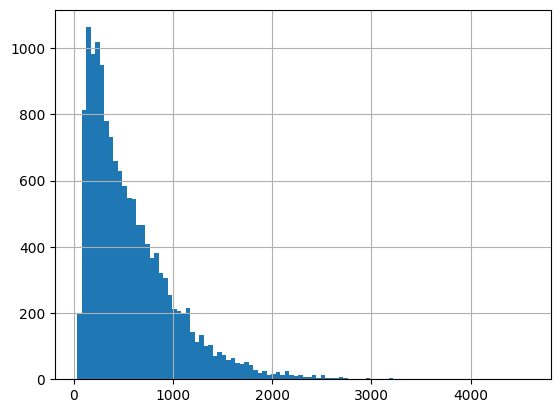

In [18]:
import matplotlib.pyplot as plt
Datadict["train"]["len_dialogue"].hist(bins=100)

<Axes: >

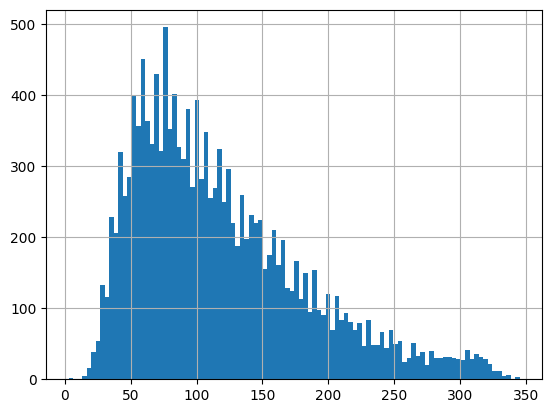

In [19]:
Datadict["train"]["len_summary"].hist(bins=100)

In [20]:
# reset to arrow format :
Datadict.reset_format()

# Delete col ["len_dialogue", "len_summary"] : 
Datadict = Datadict.remove_columns(["len_dialogue", "len_summary"])

## 5/ Choose the model (BART or T5)

In [21]:
# Define the model checkpoint :
model_checkpoint = "google-t5/t5-small"

In [22]:
# Define the devise (cuda or CPU) :
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## 6/ Data pre-processing

In [23]:
# Tokenization :
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [24]:
max_input_length = 1024
max_target_length = 200

# Preprocessing function for tokenization
def preprocess_function(examples):
    # Tokenize the dialogues
    model_inputs = tokenizer(
        examples["dialogue"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",  # Ensure all sequences are of equal length => can improve performance during training
        return_tensors="pt"  # Return PyTorch tensors 
    )
    
    # Tokenize the summaries
    labels = tokenizer(
        examples["summary"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length",  # Ensure all sequences are of equal length
        return_tensors="pt"  # Return PyTorch tensors directly
    )

    # Set the labels (output_ids)
    model_inputs["labels"] = labels["input_ids"] # output_ids <=> labels
    return model_inputs


In [25]:
tokenized_datasets = Datadict.map(preprocess_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    val1: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    val2: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})

## 7/ Metrics for text summarization

In [ ]:
#!pip install evaluate

In [ ]:
#!pip install rouge_score

In [28]:
# Rouge-score :
import evaluate

rouge_score = evaluate.load("rouge")

2024-06-22 10:47:29.489343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 10:47:29.489466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 10:47:29.613910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
# example of usage :
generated_summary = ["I absolutely loved reading the Hunger Games"]
reference_summary = ["I loved reading the Hunger Games"]

scores = rouge_score.compute(
    predictions=generated_summary, references=reference_summary, use_stemmer=True
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [30]:
# example on list :
generated_summary = ["I absolutely loved reading the Hunger Games", "I like your shirt"]
reference_summary = ["I loved reading the Hunger Games", "I like your shit"]

scores = rouge_score.compute(
    predictions=generated_summary, references=reference_summary, use_stemmer=True
)
scores

{'rouge1': 0.8365384615384615,
 'rouge2': 0.6969696969696969,
 'rougeL': 0.8365384615384615,
 'rougeLsum': 0.8365384615384615}

## 8/ Create the baseline model and evaluate the score of the baseline

### Create baseline :

In [31]:
# Create the baseline summary :
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
# example of usage : 
print(three_sentence_summary(tokenized_datasets["train"][60]["dialogue"]))

Oli :  I've talked to some people from the third year | Jacob :  About the statistics exam?
| Marcia :  What did they say?
| Oli :  Yeah ,   about the exam | Oli :  We need to prepare for a battle | Jacob :  So it will be difficult | Oli :  They said it was the hardest exam ever | Marcia :   | Oli :  The questions were displayed on the screen | Oli :  One minute per question and it disappears | Oli :  They won't come back so if you didn't get your answer you're fucked | Marcia :  So we need to make the calculations really fast | Jacob :  That's insane | Oli :  I know | Oli :  Very stressful | Marcia :  How are we even supposed to study for it?


In [33]:
# Example 2 : 
print(three_sentence_summary("I'm romain. you are paul. We are a team. yohou!"))

I'm romain.
you are paul.
We are a team.


### Evaluate baseline :

In [34]:
# evaluate baseline on validation set (val1) :
def evaluate_baseline(dataset, metric):
    summaries_baseline = [three_sentence_summary(text) for text in dataset["dialogue"]]
    return metric.compute(predictions=summaries_baseline, references=dataset["summary"])

In [35]:
import pandas as pd

score = evaluate_baseline(tokenized_datasets["val1"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 30.32, 'rouge2': 9.86, 'rougeL': 23.82, 'rougeLsum': 26.28}

## 9/ Fine-tuned the T5-small model (with TrainerAPI)

In [36]:
# Load the model :
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Attribute the devise to the model :
model.to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [37]:
# Notebook login :
# from huggingface_hub import notebook_login

# notebook_login()

In [38]:
# Set the evaluation function :
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores # to review : value.mid.fmeasure <=> value
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [39]:
# Define a data collator for the sequence-to-sequence task :
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [40]:
# Set the training argument:
from transformers import Seq2SeqTrainingArguments, TrainingArguments

"""
Gradient Accumulation: effectively increase the batch size without needing more GPU memory.
Learning Rate Scheduler: better learning rate management during training.
Mixed Precision Training: Enable mixed precision training to speed up training and reduce memory usage.
"""

batch_size = 5 #5
num_train_epochs = 30 #30
# Show the training loss with every epoch
logging_steps = 1000 #len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]


args = Seq2SeqTrainingArguments(
    seed=0,
    output_dir=f"../Model/{model_name}_Train_Args_en",  # Checkpoint path
    # Warning evaluation_strategy <=> eval_strategy
    evaluation_strategy="steps",  # Evaluate every logging step # or "epoch" or "no" 
    learning_rate=5.6e-5,  # Learning rate ######
    weight_decay=0.01,  # Weight decay for AdamW parameters optimization ######
    num_train_epochs=num_train_epochs,  # Number of epochs ######
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps to simulate larger batch size #######
    lr_scheduler_type="linear",  # Use a linear scheduler for learning rate
    metric_for_best_model="rougeL",  # Metric to determine the best model
    per_device_train_batch_size=batch_size, ######
    per_device_eval_batch_size=batch_size, ######
    predict_with_generate=True,  # Predict the summary in each step with the generate method
    logging_steps=logging_steps,  # Number of update steps between two logs
    push_to_hub=False,
    save_total_limit=2,
    load_best_model_at_end=True,  # Save the best model
    fp16=True,  # Enable mixed precision training
    save_steps=logging_steps,  # Save checkpoint every logging step  
)

In [41]:
# Instanciate the trainer (with the standard arguments):
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val1"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Launch the train :
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
30,4.998500,0.523728,0.000000,0.000000,0.000000,0.000000
60,0.689500,0.393278,0.000000,0.000000,0.000000,0.000000
90,0.447700,0.332724,1.043100,0.345400,0.791300,0.983200
120,0.371100,0.302017,22.065600,8.513000,18.069400,20.520500
150,0.333200,0.291001,34.696700,13.953500,29.195100,32.003000
180,0.333600,0.284961,36.465000,14.668400,30.525300,33.776700
210,0.323700,0.281158,36.743500,15.138100,30.786900,34.168700
240,0.322600,0.278601,36.800800,15.043400,30.791900,33.995400
270,0.309600,0.276305,37.150400,15.379400,31.301500,34.378600
300,0.309500,0.275093,37.576800,15.508200,31.613900,34.777300


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars

TrainOutput(global_step=736, training_loss=0.5219754913578862, metrics={'train_runtime': 3862.8844, 'train_samples_per_second': 7.627, 'train_steps_per_second': 0.191, 'total_flos': 7966489118244864.0, 'train_loss': 0.5219754913578862, 'epoch': 2.0})

In [42]:
# Evaluate the model on the val1 set :
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 0.26645541191101074,
 'eval_rouge1': 38.7473,
 'eval_rouge2': 16.9517,
 'eval_rougeL': 32.9838,
 'eval_rougeLsum': 36.0126,
 'eval_runtime': 51.3198,
 'eval_samples_per_second': 15.939,
 'eval_steps_per_second': 0.799,
 'epoch': 2.0}

## 10/ Save the model (localy) :

In [43]:
# save the model :
trainer.save_model(r'./T5_small_finetune_samsum_model')

In [44]:
#!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


T5_small_finetune_samsum_model	wandb


In [45]:
import shutil
shutil.make_archive("T5_small_finetune_samsum_model", 'zip', "T5_small_finetune_samsum_model")
shutil.make_archive("t5-small_Train_Args_en", 'zip', "t5-small_Train_Args_en")

'/kaggle/working/t5-small_Train_Args_en.zip'

In [46]:
# download the model
from IPython.display import FileLink
FileLink(r'./T5_small_finetune_samsum_model.zip')

/kaggle/working/T5_small_finetune_samsum_model.zip

# 11/ Valid the model by evaluating the model on the test set (val2)

In [47]:
# Define the devise (cuda or CPU) :
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [48]:
# import model :
from transformers import pipeline
pipe = pipeline('summarization', model='./T5_small_finetune_samsum_model', device=device)

In [50]:
 # Compute pred 
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8}
Datadict_val2_pred = Datadict["val2"].map(lambda df: {"pred": [pipe(txt, max_length=round(len(txt)*0.15), **gen_kwargs) for txt in df["dialogue"]]}, batched=True)
Datadict_val2_pred = Datadict_val2_pred.map(lambda df: {"pred": [[dict_pred["summary_text"] for dict_pred in pred][0] for pred in df["pred"]]}, batched=True)
Datadict_val2_pred

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Your min_length=30 must be inferior than your max_length=20.
Your min_length=30 must be inferior than your max_length=24.
Your min_length=30 must be inferior than your max_length=21.
Your min_length=30 must be inferior than your max_length=22.
Your min_length=30 must be inferior than your max_length=16.
Your min_length=30 must be inferior than your max_length=24.
Your min_length=30 must be inferior than your max_length=26.
Your min_length=30 must be inferior than your max_length=18.
Your min_length=30 must be inferior than your max_length=27.
Your min_length=30 must be inferior than your max_length=29.
Your min_length=30 must be inferior than your max_length=23.
Your min_length=30 must be inferior than your max_length=26.
Your min_length=30 must be inferior than your max_length=22.
Your min_length=30 must be inferior than your max_length=23.
Your min_length=30 must be inferior than your max_length=22.
Your min_length=30 must be inferior than your max_length=16.
Your min_length=30 must 

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'dialogue', 'summary', 'pred'],
    num_rows: 819
})

In [51]:
# Compute rouge score
rouge_score.compute(predictions=Datadict_val2_pred["pred"], references=Datadict_val2_pred["summary"], use_stemmer=True)

{'rouge1': 0.4256796396394038,
 'rouge2': 0.18693666736403164,
 'rougeL': 0.3368827190422622,
 'rougeLsum': 0.336705303134342}

## 12/ Analyse the model by testing on ONE example 

In [53]:
from transformers import pipeline

pipe = pipeline('summarization', model='./T5_small_finetune_samsum_model')

custom_dialogue="""
Romain: Hey ! Can you help me to clear the room ? 
Carla: Yes I can. Could you wait me a minute ? 
Romain: Yes of course, I will tidy the table first. 
Carla: Nice ! 
"""

# Manage the output length :
# Output_length (=max_length) == [10% ; 15%] * input_lenght
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": round(len(custom_dialogue)*0.15)}
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your min_length=30 must be inferior than your max_length=25.


Carla will tidy the table first . Romain will wait a minute for her to clear the room .


## 13/ Deploy the model in real situation

In [54]:
# Import df_val2_brut :
df_val2_brut = pd.read_parquet(r"/kaggle/input/data-txt-summarisation/Data/deployment_testing_data/conv_val2_brut.parquet", engine="pyarrow")
df_val2_brut

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\nRob: That's so gr8!\nEric: I k...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\n...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\nJane: yes, just...",Jane is in Warsaw. Ollie and Jane has a party....
...,...,...,...
814,13611902-1,Alex: Were you able to attend Friday night's b...,Benjamin didn't come to see a basketball game ...
815,13820989,Jamilla: remember that the audition starts at ...,The audition starts at 7.30 P.M. in Antena 3.
816,13717193,"Marta: <file_gif>\nMarta: Sorry girls, I click...","Marta sent a file accidentally,"
817,13829115,Cora: Have you heard how much fuss British med...,There was a meet-and-greet with James Charles ...


In [55]:
# Import model :
from transformers import pipeline
model_txtsum = pipeline('summarization', model='./T5_small_finetune_samsum_model', device=device)

In [56]:
def API_simulation(data:pd.DataFrame, input_col_name:str, model) :
    # -------------- Data cleaning 1 : ---------------------
    # Rename col : {"old_name" : "new_name"}
    col_to_rename = {"id" : "id", "dialogue" : "dialogue", "summary" : "summary"}

    # Change col type 
    col_type = {"id" : "object", "dialogue" : "object", "summary" : "object"}

    # Delete useless col
    useless_columns = None

    # Data cleaning funct
    kwarg_dc1 = {"col_to_rename": col_to_rename, "col_type": col_type, "useless_columns":useless_columns}
    df = data_cleaning_1(df=data, **kwarg_dc1)


    # ------------- Data cleaning 2 : ----------------------
    # Pandas DF to Datasets
    dataset_df = Dataset.from_pandas(df)

    # Normalized_txt
    dataset_df = dataset_df.map(normalized_txt, batched=True)

    # Correct spelling and grammar : Done
    # remove noise : Done

    # Handle emoji
    dataset_df = dataset_df.map(lambda df: {col_to_rename[input_col_name]: [emoji.demojize(txt) for txt in df[col_to_rename[input_col_name]]]}, batched=True)

    # [option] correct consistency : Done
    # [option] correct consistency in Formatting : Done
    # [option] Data filter (select specific txt) : Done


    # -------------------- Predict  ------------------------
    # Compute pred 
    gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8}
    dataset_df_pred = dataset_df.map(lambda df: {"pred": [model(txt, max_length=round(len(txt)*0.15), **gen_kwargs) for txt in df[col_to_rename[input_col_name]]]}, batched=True)
 
    # transform output/pred into list
    dataset_df_pred = dataset_df_pred.map(lambda df: {"pred": [[dict_pred["summary_text"] for dict_pred in pred][0] for pred in df["pred"]]}, batched=True)


    # --------- Create the new_data as pd.DataFrame -----------
    df_output = pd.DataFrame(dataset_df_pred)


    # ---------------- Return the new_data ----------------
    return df_output



In [57]:
# Run the API_simulation function on val2
df_val2_pred = API_simulation(data=df_val2_brut, input_col_name="dialogue", model=model_txtsum)
df_val2_pred

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Your min_length=30 must be inferior than your max_length=20.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1156: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (20). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Your min_length=30 must be inferior than your max_length=24.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1156: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (24). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Your min_length=30 must be i

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

,id,dialogue,summary,pred
0,13862856,"Hannah : Hey , do you have Betty's number? ...",Hannah needs Betty's number but Amanda doesn't...,Amanda can't find Betty's number . He called h...
1,13729565,Eric : MACHINE! | Rob : That's so gr 8 ! |...,Eric and Rob are going to watch a stand - up o...,Eric likes the train part . Rob will watch som...
2,13680171,"Lenny : Babe , can you help me with somethi...",Lenny can't decide which trousers to buy . B...,Bob has four black pairs . Lenny will buy the ...
3,13729438,"Will : hey babe , what do you want for dinn...",Emma will be home soon and she will let Will k...,"Emma will be home soon , but she'll pick her u..."
4,13828600,"Ollie : Hi , are you in Warsaw | Jane : y...",Jane is in Warsaw . Ollie and Jane has a par...,Ollie is in Warsaw for a diner on the 1 9 th ....
...,...,...,...,...
814,13611902-1,Alex : Were you able to attend Friday night's...,Benjamin didn't come to see a basketball game ...,Alex was unable to attend Friday night's baske...
815,13820989,Jamilla : remember that the audition starts a...,The audition starts at 7 . 3 0 P . M . ...,Jamilla's audition starts at 7 . 3 0 P . M .
816,13717193,"Marta : < file_gif> | Marta : Sorry girls ,...","Marta sent a file accidentally ,",Marta clicked a file_gif by accident . Weronik...
817,13829115,Cora : Have you heard how much fuss British m...,There was a meet - and - greet with James Char...,a meet and greet with James Charles in one of ...


In [ ]:
# Save the output :
# df_val2_pred.to_csv()

## 14/ Check if the Deployment is good

In [58]:
# Rouge-score :
import evaluate
rouge_score = evaluate.load("rouge")

In [59]:
# Compute rouge score (dict) :
# 1st option/ Compare with the rouge score obtained in the step 11
rouge_score.compute(predictions=df_val2_pred["pred"], references=df_val2_pred["summary"], use_stemmer=True)

{'rouge1': 0.42599040666575716,
 'rouge2': 0.1870667509171463,
 'rougeL': 0.336804997068584,
 'rougeLsum': 0.3368439087449549}

In [60]:
# 2nd option/ Or compute the rouge_score between pred from step 11 and the pred from step 13 :
rouge_score.compute(predictions=df_val2_pred["pred"], references=Datadict_val2_pred["pred"], use_stemmer=True)

{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}